In [15]:
pip install torch_geometric

In [16]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.utils.data import random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split

In [17]:
df = pd.read_csv('/content/credit_card_transaction_flow.csv')

In [18]:
# Select a random subset of 2000 records
df_subset = df.sample(n=2000, random_state=42)

In [19]:
df = df_subset

In [20]:
df.head(9)


,Customer ID,Name,Surname,Gender,Birthdate,Transaction Amount,Date,Merchant Name,Category
33553,612016,Dylan,Hoover,F,27-10-1973,74.88,17-07-2023,"Shaw, Silva and Sullivan",Restaurant
9427,852349,Theodore,Harmon,NaN,29-10-1966,220.49,11-06-2023,Dixon-Pierce,Clothing
199,59423,Franklin,Mason,F,30-10-1962,290.50,16-05-2023,"Parsons, Ballard and Kelley",Clothing
12447,460540,Christine,Lutz,F,19-10-2005,479.67,03-02-2023,Mcintosh LLC,Market
39489,409623,Jessica,Russo,F,01-11-1955,98.62,07-02-2023,Johnson-Bradley,Electronics
42724,458734,Emily,Smith,F,24-10-1985,111.16,24-08-2023,Morgan Ltd,Cosmetic
10822,117256,Gregory,Long,M,24-10-1985,219.77,21-02-2023,Carey LLC,Electronics
49498,224983,Bruce,Reynolds,M,21-10-1997,2413.12,06-10-2023,Dickerson Ltd,Travel
4144,780340,Samuel,Williams,F,30-10-1962,62.98,22-02-2023,"Martinez, Walker and Mathews",Restaurant


In [21]:
print(df.shape)
print(df.dtypes)

(2000, 9)
Customer ID             int64
Name                   object
Surname                object
Gender                 object
Birthdate              object
Transaction Amount    float64
Date                   object
Merchant Name          object
Category               object
dtype: object


In [22]:
df['Date'] = pd.to_datetime(df['Date'],format='mixed')


In [23]:
df['Birthdate'] = pd.to_datetime(df['Birthdate'],format='mixed')


In [24]:
df

,Customer ID,Name,Surname,Gender,Birthdate,Transaction Amount,Date,Merchant Name,Category
33553,612016,Dylan,Hoover,F,1973-10-27,74.88,2023-07-17,"Shaw, Silva and Sullivan",Restaurant
9427,852349,Theodore,Harmon,NaN,1966-10-29,220.49,2023-11-06,Dixon-Pierce,Clothing
199,59423,Franklin,Mason,F,1962-10-30,290.50,2023-05-16,"Parsons, Ballard and Kelley",Clothing
12447,460540,Christine,Lutz,F,2005-10-19,479.67,2023-03-02,Mcintosh LLC,Market
39489,409623,Jessica,Russo,F,1955-01-11,98.62,2023-07-02,Johnson-Bradley,Electronics
...,...,...,...,...,...,...,...,...,...
33582,353461,Robert,Hart,NaN,1976-10-26,404.64,2023-04-08,Allen Group,Market
31702,514542,Edgar,Wheeler,M,1983-10-25,224.74,2023-02-28,Hopkins PLC,Travel
38237,602426,Veronica,Jennings,M,1994-10-22,230.04,2023-04-26,"Gordon, Lewis and George",Clothing
22358,899165,Douglas,Baker,NaN,1959-10-31,386.58,2023-01-25,Martin and Sons,Electronics


In [25]:
df.isnull().sum()


Customer ID             0
Name                    0
Surname                 0
Gender                220
Birthdate               0
Transaction Amount      0
Date                    0
Merchant Name           0
Category                0
dtype: int64

In [26]:
df['Gender'] = df['Gender'].astype(str).fillna("Unknown")


In [27]:
df.isnull().sum()

Customer ID           0
Name                  0
Surname               0
Gender                0
Birthdate             0
Transaction Amount    0
Date                  0
Merchant Name         0
Category              0
dtype: int64

In [28]:
df.describe()

,Customer ID,Birthdate,Transaction Amount,Date
count,2000.000000,2000,2000.000000,2000
mean,498002.987500,1977-04-14 18:36:00,405.329940,2023-06-04 09:01:26.400000
min,427.000000,1948-02-11 00:00:00,5.930000,2023-01-01 00:00:00
25%,249314.750000,1962-10-30 00:00:00,73.525000,2023-03-20 00:00:00
50%,491862.000000,1976-10-26 00:00:00,175.190000,2023-05-30 00:00:00
75%,760124.500000,1992-10-22 00:00:00,436.460000,2023-08-19 00:00:00
max,999331.000000,2005-10-19 00:00:00,2978.790000,2023-12-10 00:00:00
std,289431.913068,NaN,587.158086,NaN


Vizualization


In [29]:
df.Category.value_counts()

Category
Restaurant     348
Market         346
Clothing       345
Cosmetic       330
Electronics    328
Travel         303
Name: count, dtype: int64

In [30]:
dfcat = df[['Category','Transaction Amount']].groupby('Category').agg(['sum','mean']).reset_index()

In [31]:
dfcat.columns = ['Category','Sum of Transactions','Mean of Transactions']


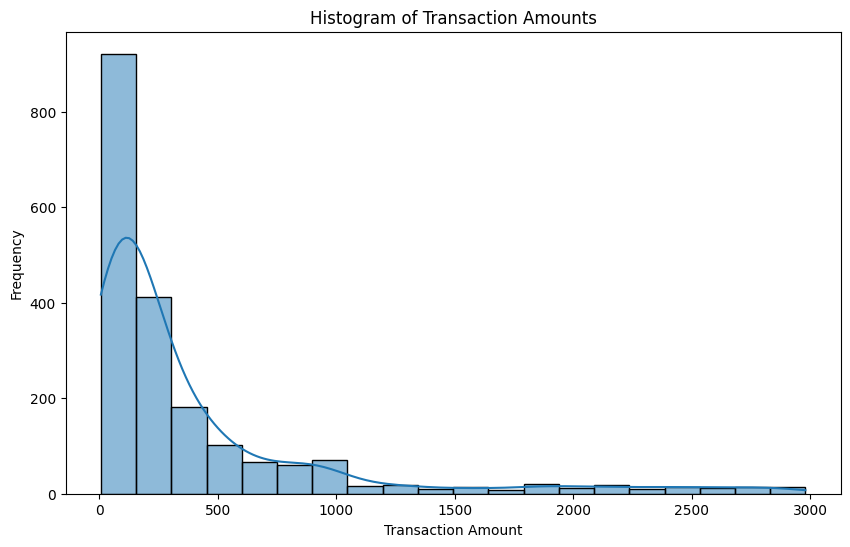

In [32]:
# 1. Histogram of transaction amounts
plt.figure(figsize=(10, 6))
sns.histplot(df['Transaction Amount'], bins=20, kde=True)
plt.title('Histogram of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()


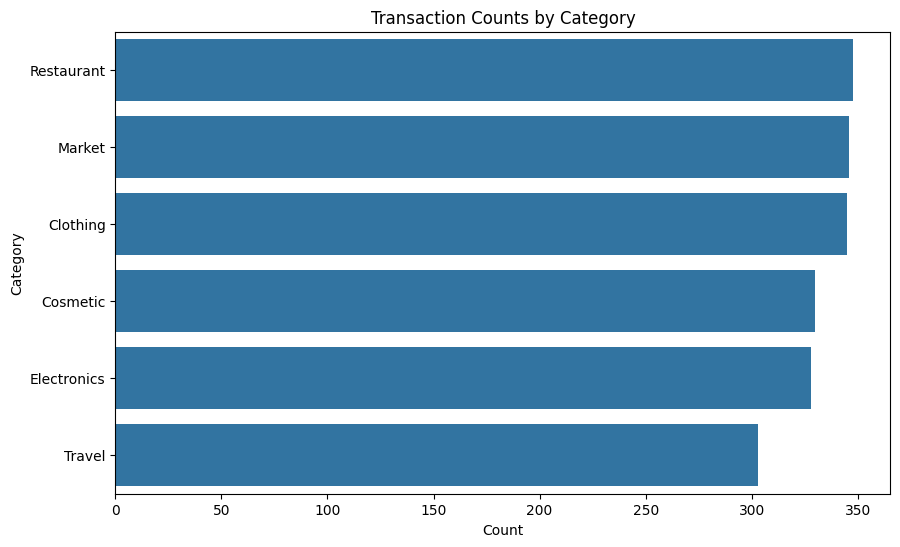

In [33]:
# 2. Bar chart of transaction counts by category
plt.figure(figsize=(10, 6))
sns.countplot(y='Category', data=df, order=df['Category'].value_counts().index)
plt.title('Transaction Counts by Category')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

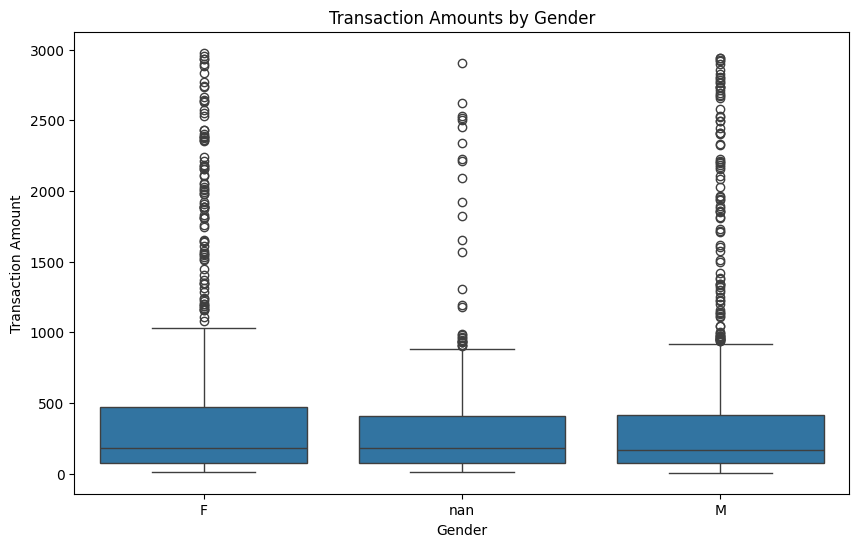

In [34]:
# 3. Box plot of transaction amounts by gender
plt.figure(figsize=(10, 6))
sns.boxplot(x='Gender', y='Transaction Amount', data=df)
plt.title('Transaction Amounts by Gender')
plt.xlabel('Gender')
plt.ylabel('Transaction Amount')
plt.show()

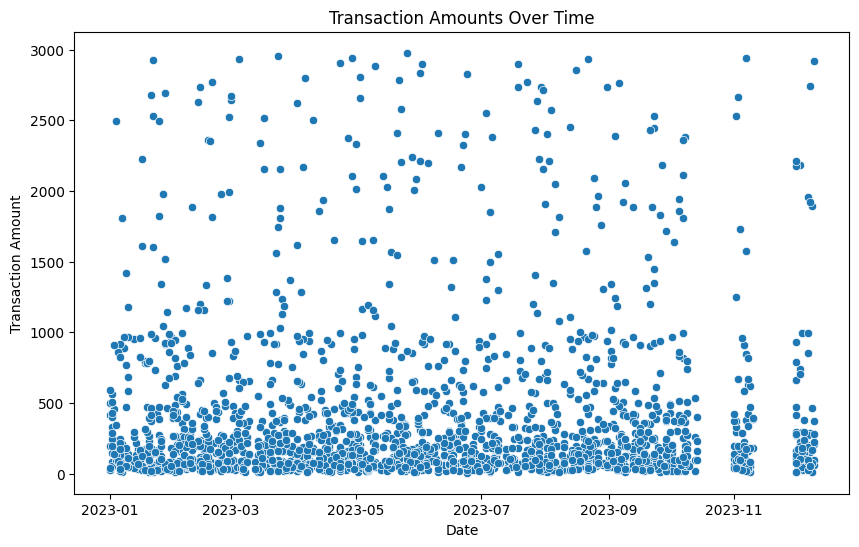

In [35]:
# 4. Scatter plot of transaction amounts over time
df['Date'] = pd.to_datetime(df['Date'])
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Date', y='Transaction Amount', data=df)
plt.title('Transaction Amounts Over Time')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')
plt.show()

In [38]:
pip install infomap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.1/263.1 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for infomap: filename=infomap-2.7.1-cp310-cp310-linux_x86_64.whl size=7690299 sha256=9d48d20d8069fd00ee78250b89a20b36c2a3a3500993ff71d01ca90679a1a470
  Stored in directory: /root/.cache/pip/wheels/e4/01/53/fd7c62079098140cd582b999592b4592c0dad7300cac32b6e1
Successfully built infomap


Girvan-Newman Communities: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 5, 2, 2, 2, 6, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 3, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 4, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 4, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

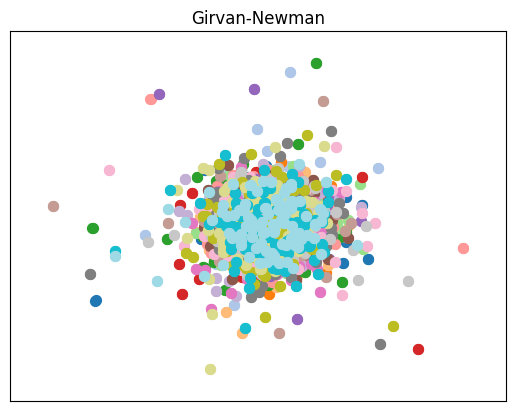

Louvain Communities: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 5, 2, 2, 2, 6, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 3, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 4, 2, 2, 2, 2, 2, 2, 2, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 4, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

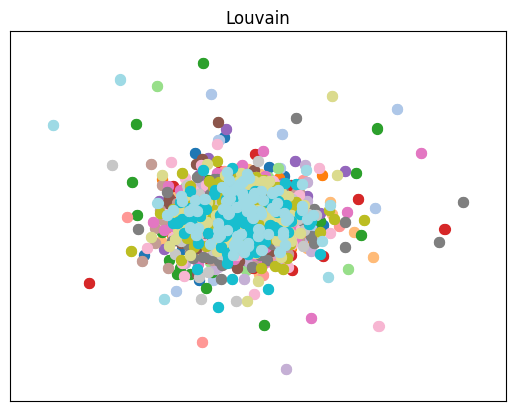

Infomap Communities: [6, 7, 7, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 8, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 5, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 5, 4, 3, 3, 3, 3, 6, 4, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 

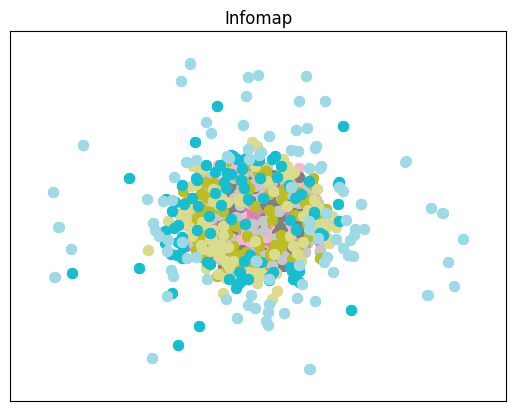

Label Propagation Communities: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 5, 2, 2, 2, 6, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 3, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 4, 2, 2, 2, 2, 2, 2, 2, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 4, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

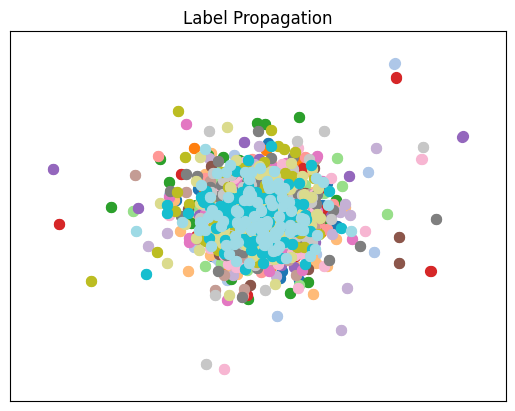

Epoch 0, Loss: 0.6927
Epoch 20, Loss: 0.6305
Epoch 40, Loss: 0.5701
Epoch 60, Loss: 0.5026
Epoch 80, Loss: 0.4384
Epoch 100, Loss: 0.3843
Epoch 120, Loss: 0.3397
Epoch 140, Loss: 0.3052
Epoch 160, Loss: 0.2777
Epoch 180, Loss: 0.2549
Accuracy: 1.0000
Epoch 0, Loss: 7.8186
Epoch 20, Loss: 6.6224
Epoch 40, Loss: 6.2493
Epoch 60, Loss: 6.0342
Epoch 80, Loss: 5.8806
Epoch 100, Loss: 5.7675
Epoch 120, Loss: 5.7049
Epoch 140, Loss: 5.6098
Epoch 160, Loss: 5.5478
Epoch 180, Loss: 5.4666
Accuracy: 0.0245


In [39]:
import pandas as pd
import networkx as nx
from networkx.algorithms import community as nx_comm
import community.community_louvain as community_louvain
from infomap import Infomap
import itertools
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from torch.utils.data import DataLoader, Dataset
import numpy as np

# # Load the dataset
# data_path = 'credit_card_transaction_flow.csv'
# df = pd.read_csv(data_path)

# Preprocess the dataset
df.fillna('', inplace=True)
df['Customer ID'] = df['Customer ID'].astype(str)
df['Merchant Name'] = df['Merchant Name'].astype(str)

# Feature Engineering: Create nodes and edges datasets
customer_nodes = df[['Customer ID', 'Gender', 'Birthdate']].drop_duplicates().copy()
merchant_nodes = df[['Merchant Name']].drop_duplicates().copy()
customer_nodes['node_type'] = 'customer'
merchant_nodes['node_type'] = 'merchant'
merchant_nodes.columns = ['ID', 'node_type']
nodes = pd.concat([customer_nodes.rename(columns={'Customer ID': 'ID'}), merchant_nodes], ignore_index=True)
edges = df[['Customer ID', 'Merchant Name', 'Transaction Amount', 'Date']]
edges.columns = ['source', 'target', 'weight', 'date']

# Create graph
G = nx.Graph()
for idx, row in nodes.iterrows():
    G.add_node(row['ID'], node_type=row['node_type'], gender=row.get('Gender', None), birthdate=row.get('Birthdate', None))
for idx, row in edges.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['weight'], date=row['date'])

# Define a function to plot communities
def plot_communities(G, communities, title):
    pos = nx.spring_layout(G)
    colors = [plt.cm.tab20(i / len(communities)) for i in range(len(communities))]
    for community, color in zip(communities, colors):
        nx.draw_networkx_nodes(G, pos, nodelist=list(community), node_color=[color], node_size=50)
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.title(title)
    plt.show()

# Girvan-Newman Algorithm
def girvan_newman(G, num_communities=4):
    comp = nx_comm.girvan_newman(G)
    limited = itertools.islice(comp, num_communities - 1)
    communities = [list(c) for c in next(limited)]
    return communities

gn_communities = girvan_newman(G, num_communities=4)
print(f"Girvan-Newman Communities: {[len(c) for c in gn_communities]}")
plot_communities(G, gn_communities, 'Girvan-Newman')

# Louvain Algorithm
def louvain(G, resolution=1.0):
    partition = community_louvain.best_partition(G, resolution=resolution)
    communities = {}
    for node, community in partition.items():
        communities.setdefault(community, []).append(node)
    return list(communities.values())

louvain_communities = louvain(G, resolution=1.0)
print(f"Louvain Communities: {[len(c) for c in louvain_communities]}")
plot_communities(G, louvain_communities, 'Louvain')

# Infomap Algorithm
def infomap(G):
    im = Infomap()
    node_map = {node: i for i, node in enumerate(G.nodes)}
    for e in G.edges(data=True):
        im.addLink(node_map[e[0]], node_map[e[1]], float(e[2]['weight']) if 'weight' in e[2] else 1.0)
    im.run()
    communities = {}
    for node_id in im.tree:
        if node_id.isLeaf:
            original_node = list(node_map.keys())[list(node_map.values()).index(node_id.node_id)]
            communities.setdefault(node_id.moduleIndex(), []).append(original_node)
    return list(communities.values())

infomap_communities = infomap(G)
print(f"Infomap Communities: {[len(c) for c in infomap_communities]}")
plot_communities(G, infomap_communities, 'Infomap')

# Label Propagation Algorithm
def label_propagation(G):
    communities = list(nx_comm.label_propagation_communities(G))
    return [list(community) for community in communities]

lp_communities = label_propagation(G)
print(f"Label Propagation Communities: {[len(c) for c in lp_communities]}")
plot_communities(G, lp_communities, 'Label Propagation')

# GCN Model
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Prepare data for GCN
le = LabelEncoder()
features = np.identity(len(G.nodes))  # Identity matrix as features
labels = le.fit_transform([d['node_type'] for n, d in G.nodes(data=True)])

# Create a mapping from node IDs to integers
node_mapping = {node: i for i, node in enumerate(G.nodes)}
edges_mapped = [(node_mapping[edge[0]], node_mapping[edge[1]]) for edge in G.edges]

data = from_networkx(G)
data.x = torch.tensor(features, dtype=torch.float)
data.edge_index = torch.tensor(edges_mapped, dtype=torch.long).t().contiguous()
data.y = torch.tensor(labels, dtype=torch.long)

# Train GCN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(input_dim=data.num_node_features, hidden_dim=16, output_dim=len(set(labels))).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(200):
    loss = train()
    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

# Evaluate GCN
model.eval()
_, pred = model(data).max(dim=1)
correct = pred.eq(data.y).sum().item()
acc = correct / len(data.y)
print(f'Accuracy: {acc:.4f}')

# LSTM Model
class TransactionDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.customers = df['Customer ID'].unique()

    def __len__(self):
        return len(self.customers)

    def __getitem__(self, idx):
        customer = self.customers[idx]
        transactions = self.df[self.df['Customer ID'] == customer]
        features = transactions[['Transaction Amount']].values
        return torch.tensor(features, dtype=torch.float), torch.tensor(idx, dtype=torch.long)

class LSTMModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_dim).to(x.device)
        c0 = torch.zeros(1, x.size(0), hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Prepare data for LSTM
dataset = TransactionDataset(df)  # Use the original DataFrame here
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

input_dim = 1
hidden_dim = 16
output_dim = len(dataset)
num_layers = 1

lstm_model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)

# Train LSTM
def train_lstm():
    lstm_model.train()
    total_loss = 0
    for features, labels in dataloader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = lstm_model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

for epoch in range(200):
    loss = train_lstm()
    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

# Evaluate LSTM
lstm_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for features, labels in dataloader:
        features, labels = features.to(device), labels.to(device)
        outputs = lstm_model(features)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy: {accuracy:.4f}')
